In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import xarray
import os
import subprocess

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 10) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;

Populating the interactive namespace from numpy and matplotlib


In [2]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

In [4]:
#add nco stuff here
# Fields to process for each run, define baseline and experiment here and workdir and variables to extract
# Define workdir -- should be a place you have write access to
workdir = '/lcrc/group/acme/lvanroe/regridded_files'

baseline = '20170821.FCTfix-GM.GMPAS-IAF.T62_oECv3.anvil'
experiment = '20170830.test.GMPAS-IAF.T62_oECv3.anvil'
basePath = '/lcrc/group/acme/jwolfe/acme_scratch/'+baseline+'/run/'
expPath = '/lcrc/group/acme/jwolfe/acme_scratch/'+experiment+'/run/'

#files to average in standard glob format
filenames = [basePath+'mpaso.hist.0005*',expPath+'mpaso.hist.0005*']
outfiles = ['baseline.nc','experiment.nc']

# List time period of interest 
# Variable to process if you want more than one, a comma separated list is acceptable
variables_list = ['potentialDensity','temperature']
variables_to_process = ','.join(variables_list)

#remove directory if exists FIX LATER -- should be better way to move/rename files from previous runs
if os.path.isdir(workdir):
    subprocess.check_call(['rm','-r',workdir])
    
os.mkdir(workdir)

os.chdir(workdir)

for i in range(2):
# First pull all files into 1 file
    args = 'ncrcat -v '+variables_to_process+' '+filenames[i]+' tmp.nc'
    #'['ncrcat','-v',variables_to_process,filenames,'tmp.nc']
    subprocess.check_output(args,shell=True,stderr=subprocess.STDOUT)

    # Average over files
    args = ['ncra','tmp.nc','temp.nc']
    subprocess.check_call(args)

    subprocess.check_call(['rm','tmp.nc'])

    #Add mesh information for ncremap
    args = ['ncks','-v','latCell,lonCell','-A','/home/ccsm-data/inputdata/ocn/mpas-o/oEC60to30v3/oEC60to30v3_60layer.170506.nc','temp.nc']
    subprocess.check_call(args)

    #Remap
    args = 'ncremap -i temp.nc -o '+outfiles[i]+' -P mpas -m /lcrc/group/acme/lvanroe/' + \
            'APrime_Files/mapping/maps/map_oEC60to30v3_TO_0.5x0.5degree_blin.nc -R ' + \
            '"--rgr lat_nm=latCell --rgr lon_nm=lonCell --rgr lat_nm_out=lat --rgr lon_nm_out=lon" -C'
    subprocess.check_output(args,shell=True,stderr=subprocess.STDOUT)
    
    subprocess.check_call(['rm','temp.nc'])

In [5]:
#open baseline and experiment for analysis

dsBaseline = xarray.open_dataset('baseline.nc')
dsExperiment = xarray.open_dataset('experiment.nc')

In [6]:
#open mesh for z-levels
mesh60 = xarray.open_dataset('/home/ccsm-data/inputdata/ocn/mpas-o/oEC60to30v3/oEC60to30v3_60layer.170506.nc')

In [7]:
#build a mask 
pd = dsBaseline.potentialDensity[0,:,:,:].values
mask = np.zeros_like(pd)
mask2 = np.zeros_like(pd)
for i in range(pd.shape[0]):
    for j in range(pd.shape[1]):
        for k in range(pd.shape[2]):
            if pd[i,j,k] < 900:
                mask[i,j,k] = np.nan
                mask2[i,j,k] = 1.0
            else:
                mask[i,j,k] = 1.0

In [9]:
#create an area array that is 3D
area1 = dsBaseline.area.values
nz = dsBaseline.dims['nVertLevels']
nLat = dsBaseline.dims['lat']
nLon = dsBaseline.dims['lon']
areaArray = np.zeros_like(mask2)
for i in range(nz):
    areaArray[i,:,:] = area1

In [36]:
#Assumes zonal average, set below flag to true to flip
meridionalAverage = True

#Specify lon/lat bounds for averaging NOTE: remapped longitudes run -180 to 180
latmin = -60
latmax = -58
lonmin = -180
lonmax = 180

lonIndex = np.where((dsBaseline.lon.values > lonmin) & (dsBaseline.lon.values < lonmax))[0]
latIndex = np.where((dsBaseline.lat.values > latmin) & (dsBaseline.lat.values < latmax))[0]
startLat = latIndex[0]
stopLat = latIndex[-1]
startLon = lonIndex[0]
stopLon = lonIndex[-1]

if not meridionalAverage:
    maskav = np.mean(mask2[:,startLat:stopLat,startLon:stopLon]*areaArray[:,startLat:stopLat,startLon:stopLon] \
                     ,axis=2) / np.nanmean(areaArray[:,startLat:stopLat,startLon:stopLon],axis=2)
else:
    maskav = np.mean(mask2[:,startLat:stopLat,startLon:stopLon]*areaArray[:,startLat:stopLat,startLon:stopLon] \
                     ,axis=1) / np.nanmean(areaArray[:,startLat:stopLat,startLon:stopLon],axis=1)
    

/lcrc/group/acme/lvanroe/conda/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/lcrc/group/acme/lvanroe/conda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


1025.06661637 1030.31619372


/lcrc/group/acme/lvanroe/conda/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less


-3.90138706763 5.59809457414


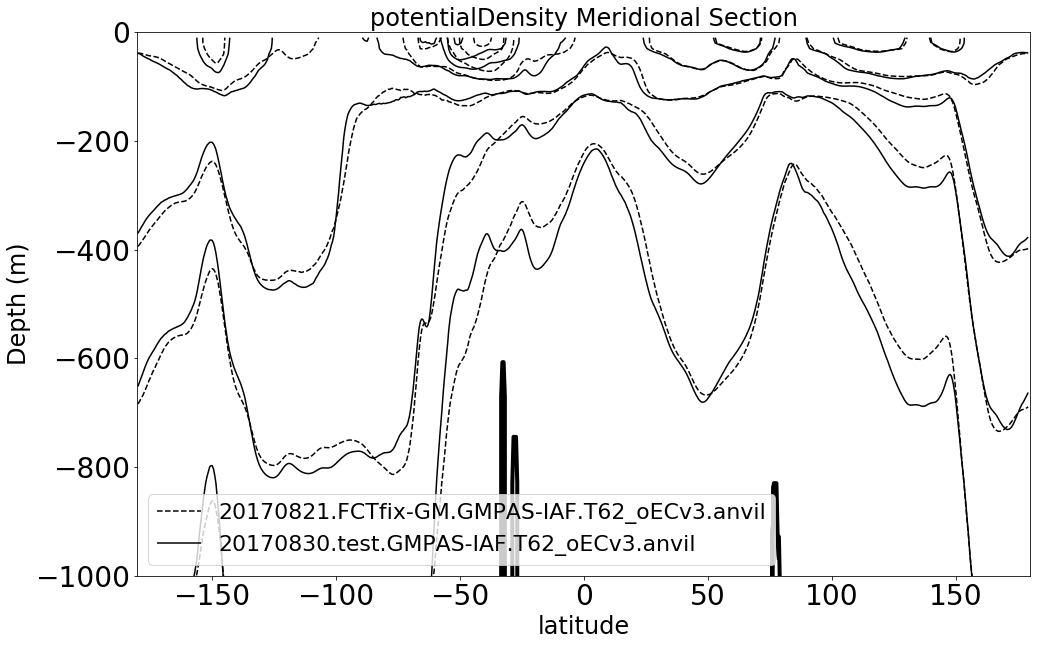

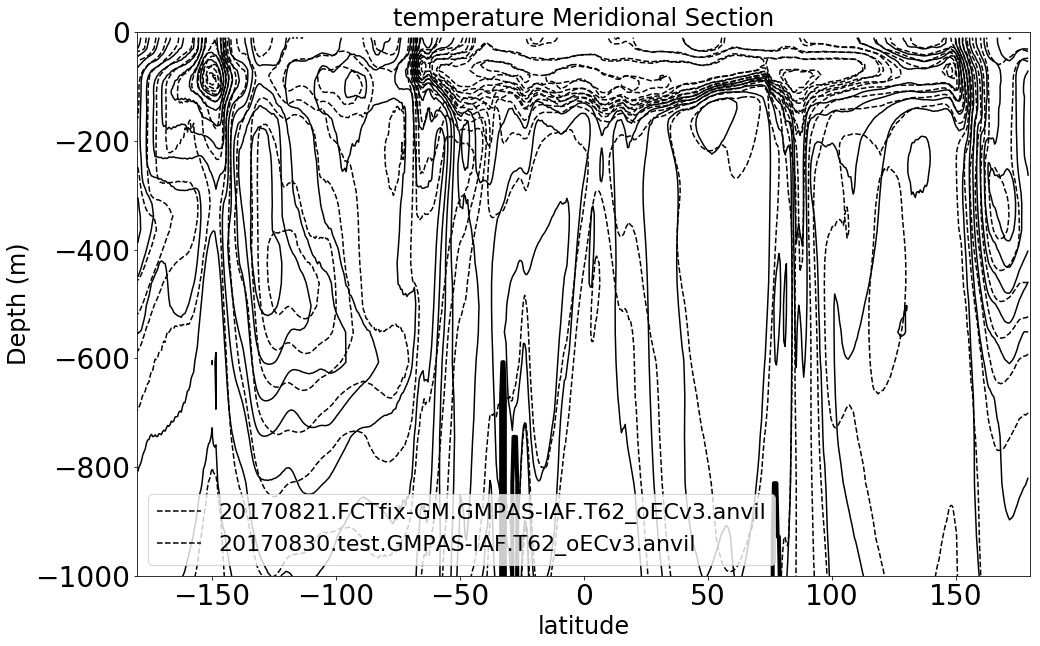

In [78]:
#specify minimum depth to cionsider as zmin
zmin = -1000
zInd = abs(zmin+mesh60.refBottomDepth.values).argmin()
for i,varname in enumerate(variables_list):
    
    if not meridionalAverage:
        # Zonal average
        baseAverage = np.mean(dsBaseline[varname][0,:,startLat:stopLat,startLon:stopLon].values* \
                             mask[:,startLat:stopLat,startLon:stopLon]*areaArray[:,startLat:stopLat,startLon:stopLon], \
                             axis=2) / np.mean(areaArray[:,startLat:stopLat,startLon:stopLon],axis=2)
        expAverage = np.mean(dsExperiment[varname][0,:,startLat:stopLat,startLon:stopLon].values* \
                             mask[:,startLat:stopLat,startLon:stopLon]*areaArray[:,startLat:stopLat,startLon:stopLon], \
                             axis=2) / np.mean(areaArray[:,startLat:stopLat,startLon:stopLon],axis=2)
        #make plot
        
        fig,ax = plt.subplots()
        cboundLow = max(np.nanmin(baseAverage[:zInd,:]),np.nanmin(expAverage[:zInd,:]))
        cboundHigh = min(np.nanmax(baseAverage[:zInd,:]),np.nanmax(expAverage[:zInd,:]))
        
        # the following if block accounts for the mpas -1e33 fill value
        if cboundLow < -1000:
            inds=np.where(baseAverage<-1000)
            baseAverage[inds[0],inds[1]] = np.nan
            expAverage[inds[0],inds[1]] = np.nan
            cboundLow = max(np.nanmin(baseAverage[:zInd,:]),np.nanmin(expAverage[:zInd,:]))
       
        CS1 = ax.contour(dsExperiment.lat[startLat:stopLat],-mesh60.refBottomDepth,expAverage,levels=np.linspace(cboundLow,cboundHigh,21),colors='k')
        CS2 = ax.contour(dsBaseline.lat[startLat:stopLat],-mesh60.refBottomDepth,baseAverage,levels=np.linspace(cboundLow,cboundHigh,21),colors='k',linestyles='dashed')
        ax.contour(dsBaseline.lat[startLat:stopLat],-mesh60.refBottomDepth,maskav,levels=[0,1],colors='k',linewidths=4)
        ax.set_xlim(latmin,latmax)
        ax.set_ylim(-1000,0)
        ax.set_ylabel('Depth (m)',fontsize=24)
        ax.set_xlabel('latitude',fontsize=24)
        ax.set_title(variables_list[i]+' Zonal Section',fontsize=24)
        labels = [baseline,experiment]
        lines = [CS2.collections[0],CS1.collections[0]]
        plt.legend(lines,labels,fontsize=22,loc='lower left')

    else:
        baseAverage = np.nanmean(dsBaseline[varname][0,:,startLat:stopLat,startLon:stopLon].values* \
                             mask[:,startLat:stopLat,startLon:stopLon]*areaArray[:,startLat:stopLat,startLon:stopLon], \
                             axis=1) / np.nanmean(areaArray[:,startLat:stopLat,startLon:stopLon],axis=1)
        expAverage = np.nanmean(dsExperiment[varname][0,:,startLat:stopLat,startLon:stopLon].values* \
                             mask[:,startLat:stopLat,startLon:stopLon]*areaArray[:,startLat:stopLat,startLon:stopLon], \
                             axis=1) / np.nanmean(areaArray[:,startLat:stopLat,startLon:stopLon],axis=1)
        
        fig,ax = plt.subplots()
        
        #bound base on 3 standard deviations from mean
        basebound = np.nanmean(baseAverage[:zInd,:],axis=1) - 2*np.nanstd(baseAverage[:zInd,:],axis=1)
        expbound = np.nanmean(expAverage[:zInd,:],axis=1) - 2*np.nanstd(expAverage[:zInd,:],axis=1)

        cboundLow = max(np.nanmin(basebound),np.nanmin(expbound))
        
        basebound = np.nanmean(baseAverage[:zInd,:],axis=1) + 2*np.nanstd(baseAverage[:zInd,:],axis=1)
        expbound = np.nanmean(expAverage[:zInd,:],axis=1) + 2*np.nanstd(expAverage[:zInd,:],axis=1)
        cboundHigh = min(np.nanmax(basebound),np.nanmax(expbound))
        
        
        # the following if block accounts for the mpas -1e33 fill value
        if cboundLow < -1000:
            inds=np.where(baseAverage<-1000)
            baseAverage[inds[0],inds[1]] = np.nan
            expAverage[inds[0],inds[1]] = np.nan
            basebound = np.nanmean(baseAverage[:zInd,:],axis=1) - 2*np.nanstd(baseAverage[:zInd,:],axis=1)
            expbound = np.nanmean(expAverage[:zInd,:],axis=1) - 2*np.nanstd(expAverage[:zInd,:],axis=1)

            cboundLow = max(np.nanmin(basebound),np.nanmin(expbound))
            
            basebound = np.nanmean(baseAverage[:zInd,:],axis=1) + 2*np.nanstd(baseAverage[:zInd,:],axis=1)
            expbound = np.nanmean(expAverage[:zInd,:],axis=1) + 2*np.nanstd(expAverage[:zInd,:],axis=1)
            cboundHigh = min(np.nanmax(basebound),np.nanmax(expbound))
        
        CS1 = ax.contour(dsExperiment.lon[startLon:stopLon],-mesh60.refBottomDepth,expAverage,levels=np.linspace(cboundLow,cboundHigh,21),colors='k')
        CS2 = ax.contour(dsBaseline.lon[startLon:stopLon],-mesh60.refBottomDepth,baseAverage,levels=np.linspace(cboundLow,cboundHigh,21),colors='k',linestyles='dashed')
        ax.contour(dsBaseline.lon[startLon:stopLon],-mesh60.refBottomDepth,maskav,levels=[0,1],colors='k',linewidths=4)
        ax.set_xlim(lonmin,lonmax)
        ax.set_ylim(-1000,0)
        ax.set_ylabel('Depth (m)',fontsize=24)
        ax.set_xlabel('latitude',fontsize=24)
        ax.set_title(variables_list[i]+' Meridional Section',fontsize=24)
        labels = [baseline,experiment]
        lines = [CS2.collections[0],CS1.collections[0]]
        plt.legend(lines,labels,fontsize=22,loc='lower left')
